# Face Detection and Anonymization System

This notebook implements a computer vision system for detecting faces in images and anonymizing them using face swapping techniques.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Face Detection](#detection)
3. [Face Landmark Detection](#landmarks)
4. [Face Swapping](#swapping)
5. [Testing and Evaluation](#testing)

## 1. Setup and Imports <a name="setup"></a>

First, let's install and import all necessary libraries for our face detection and anonymization system.

In [9]:
# Install required packages (compatible with Python 3.13)
!pip install opencv-python opencv-contrib-python
!pip install numpy matplotlib
!pip install Pillow
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [10]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from typing import List, Tuple, Optional
from scipy.spatial import Delaunay

# Set matplotlib to display images inline
%matplotlib inline

# Set up plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Python version: 3.13.9 (using OpenCV-only solution)")

✓ All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6
Python version: 3.13.9 (using OpenCV-only solution)


### Helper Functions for Visualization

Let's create some utility functions to display images properly in the notebook.

In [11]:
def display_image(image, title="Image", cmap=None, figsize=(10, 6)):
    """
    Display an image using matplotlib.
    
    Args:
        image: Image array (BGR or RGB)
        title: Title for the plot
        cmap: Color map (None for RGB, 'gray' for grayscale)
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Convert BGR to RGB for display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_images_grid(images, titles, rows=1, cols=2, figsize=(15, 8)):
    """
    Display multiple images in a grid.
    
    Args:
        images: List of images
        titles: List of titles
        rows: Number of rows
        cols: Number of columns
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for idx, (image, title) in enumerate(zip(images, titles)):
        if idx < len(axes):
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(image)
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined!")

✓ Visualization functions defined!


## 2. Face Detection <a name="detection"></a>

We'll implement face detection using multiple methods:
- Haar Cascade (OpenCV)
- DNN-based face detector (more accurate)

### 2.1 Haar Cascade Face Detection

In [12]:
class FaceDetector:
    """
    A class for detecting faces in images using various methods.
    """
    
    def __init__(self, method='haar'):
        """
        Initialize the face detector.
        
        Args:
            method: Detection method ('haar' or 'dnn')
        """
        self.method = method
        
        if method == 'haar':
            # Load Haar Cascade classifier
            self.face_cascade = cv2.CascadeClassifier(
                cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            )
            print("✓ Haar Cascade loaded")
            
        elif method == 'dnn':
            # Load DNN model for face detection
            self.model_file = "res10_300x300_ssd_iter_140000.caffemodel"
            self.config_file = "deploy.prototxt"
            
            # Note: You'll need to download these files
            # We'll provide download instructions
            try:
                self.net = cv2.dnn.readNetFromCaffe(self.config_file, self.model_file)
                print("✓ DNN model loaded")
            except:
                print("⚠ DNN model files not found. Using Haar Cascade instead.")
                self.method = 'haar'
                self.face_cascade = cv2.CascadeClassifier(
                    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
                )
    
    def detect_faces_haar(self, image, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
        """
        Detect faces using Haar Cascade.
        
        Args:
            image: Input image (BGR)
            scale_factor: Parameter specifying how much the image size is reduced at each image scale
            min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have
            min_size: Minimum possible object size
            
        Returns:
            List of face bounding boxes [(x, y, w, h), ...]
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = self.face_cascade.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size
        )
        
        return faces
    
    def detect_faces_dnn(self, image, confidence_threshold=0.5):
        """
        Detect faces using DNN model.
        
        Args:
            image: Input image (BGR)
            confidence_threshold: Minimum confidence for detection
            
        Returns:
            List of face bounding boxes [(x, y, w, h), ...]
        """
        h, w = image.shape[:2]
        
        # Prepare blob for DNN
        blob = cv2.dnn.blobFromImage(
            cv2.resize(image, (300, 300)),
            1.0,
            (300, 300),
            (104.0, 177.0, 123.0)
        )
        
        # Forward pass
        self.net.setInput(blob)
        detections = self.net.forward()
        
        # Extract faces with high confidence
        faces = []
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            
            if confidence > confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x, y, x2, y2) = box.astype("int")
                faces.append((x, y, x2-x, y2-y))
        
        return np.array(faces)
    
    def detect(self, image, **kwargs):
        """
        Detect faces using the selected method.
        
        Args:
            image: Input image (BGR)
            **kwargs: Additional parameters for the detection method
            
        Returns:
            List of face bounding boxes
        """
        if self.method == 'haar':
            return self.detect_faces_haar(image, **kwargs)
        elif self.method == 'dnn':
            return self.detect_faces_dnn(image, **kwargs)
    
    def draw_faces(self, image, faces, color=(0, 255, 0), thickness=2):
        """
        Draw bounding boxes around detected faces.
        
        Args:
            image: Input image
            faces: List of face bounding boxes
            color: Rectangle color (BGR)
            thickness: Rectangle thickness
            
        Returns:
            Image with drawn rectangles
        """
        result = image.copy()
        
        for (x, y, w, h) in faces:
            cv2.rectangle(result, (x, y), (x+w, y+h), color, thickness)
            # Add label
            cv2.putText(result, 'Face', (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        return result

print("✓ FaceDetector class defined!")

✓ FaceDetector class defined!


### 2.2 Test Face Detection

Let's test the face detector with a sample image.

In [13]:
# Initialize the face detector
detector = FaceDetector(method='haar')

# For testing, let's create a simple test or load an image
# You can replace this with your own image path
print("Face detector initialized!")
print("To test, load an image using: image = cv2.imread('path/to/your/image.jpg')")

✓ Haar Cascade loaded
Face detector initialized!
To test, load an image using: image = cv2.imread('path/to/your/image.jpg')


Found 2 face(s)


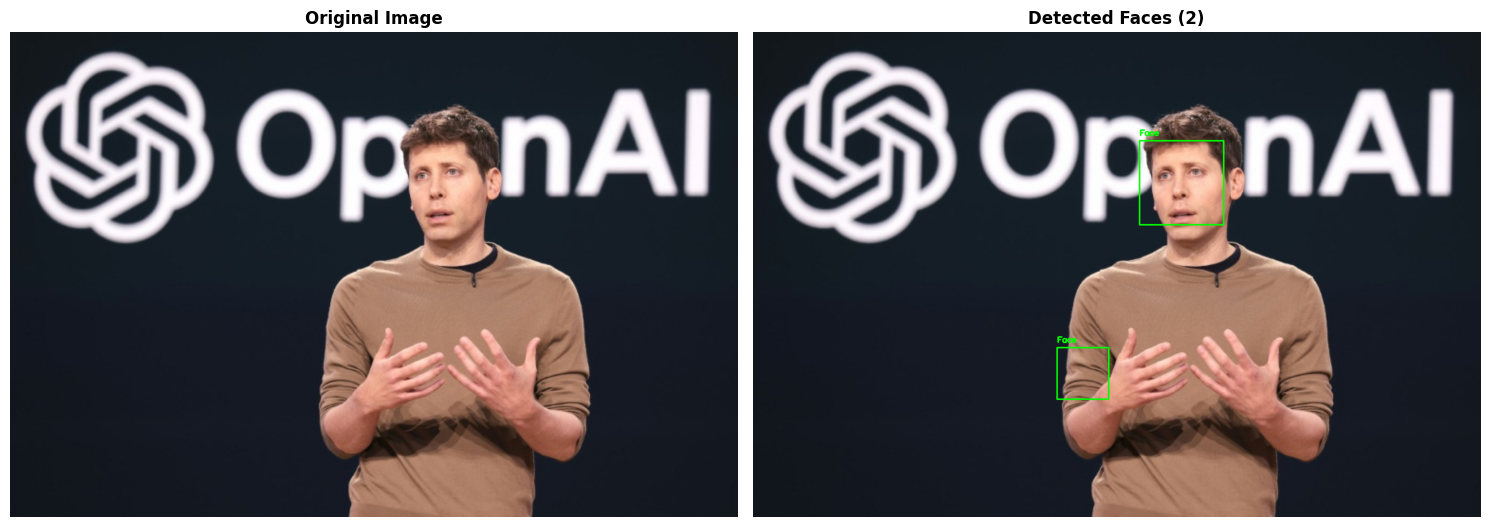

In [18]:
# Example: Load and detect faces in an image
# Uncomment and modify the path to test with your own image

image_path = '../assets/sam_altman.jpg'
image = cv2.imread(image_path)

if image is not None:
    # Detect faces
    faces = detector.detect(image)
    print(f"Found {len(faces)} face(s)")
    
    # Draw bounding boxes
    result = detector.draw_faces(image, faces)
    
    # Display results
    display_images_grid(
        [image, result],
        ['Original Image', f'Detected Faces ({len(faces)})'],
        rows=1, cols=2
    )
else:
    print("Could not load image. Please check the path.")

## 3. Face Landmark Detection <a name="landmarks"></a>

Face landmarks are key points on the face (eyes, nose, mouth, etc.) that help us align and swap faces accurately.

We'll use OpenCV's built-in face landmark detector (Facemark) which works perfectly with Python 3.13.

In [20]:
# Download facial landmark model for OpenCV
import urllib.request

def download_landmark_model():
    """
    Download the OpenCV face landmark model if not already present.
    """
    model_path = "lbfmodel.yaml"
    
    if not os.path.exists(model_path):
        print("Downloading facial landmark model...")
        url = "https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml"
        
        try:
            urllib.request.urlretrieve(url, model_path)
            print("✓ Landmark model downloaded!")
        except Exception as e:
            print(f"⚠ Could not download model: {e}")
            print("You can download manually from:")
            print("https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml")
            return None
    else:
        print("✓ Landmark model already exists!")
    
    return model_path

# Download the model
landmark_model_path = download_landmark_model()

✓ Landmark model already exists!


In [22]:
class FaceLandmarkDetector:
    """
    A class for detecting facial landmarks using OpenCV Facemark.
    """
    
    def __init__(self, model_path="lbfmodel.yaml"):
        """
        Initialize the landmark detector using OpenCV Facemark.
        
        Args:
            model_path: Path to the LBF model file
        """
        try:
            # Create Facemark LBF detector
            self.facemark = cv2.face.createFacemarkLBF()
            
            if os.path.exists(model_path):
                self.facemark.loadModel(model_path)
                self.model_loaded = True
                print("✓ OpenCV Facemark initialized with LBF model!")
            else:
                self.model_loaded = False
                print("⚠ Model file not found. Will use simple landmark estimation.")
                
        except Exception as e:
            print(f"⚠ Could not initialize Facemark: {e}")
            print("Falling back to simple landmark estimation based on face detection.")
            self.facemark = None
            self.model_loaded = False
    
    def estimate_landmarks_from_face(self, image, face_rect):
        """
        Estimate basic facial landmarks from face bounding box.
        This is a fallback when the model isn't available.
        
        Args:
            image: Input image (BGR)
            face_rect: Face bounding box (x, y, w, h)
            
        Returns:
            Array of estimated landmark points
        """
        x, y, w, h = face_rect
        
        # Estimate key facial points based on typical face proportions
        landmarks = []
        
        # Face outline (17 points)
        for i in range(17):
            ratio = i / 16.0
            lx = int(x + w * 0.1 + w * 0.8 * ratio)
            ly = int(y + h * (0.2 + 0.6 * abs(ratio - 0.5)))
            landmarks.append([lx, ly])
        
        # Eyebrows (10 points)
        # Right eyebrow
        for i in range(5):
            lx = int(x + w * (0.2 + i * 0.08))
            ly = int(y + h * 0.3)
            landmarks.append([lx, ly])
        
        # Left eyebrow
        for i in range(5):
            lx = int(x + w * (0.56 + i * 0.08))
            ly = int(y + h * 0.3)
            landmarks.append([lx, ly])
        
        # Nose (9 points)
        for i in range(9):
            lx = int(x + w * 0.5)
            ly = int(y + h * (0.35 + i * 0.05))
            landmarks.append([lx, ly])
        
        # Eyes (12 points)
        # Right eye
        eye_x = x + int(w * 0.3)
        eye_y = y + int(h * 0.4)
        eye_w = int(w * 0.15)
        for i in range(6):
            angle = i * np.pi / 3
            lx = int(eye_x + eye_w * np.cos(angle))
            ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Left eye
        eye_x = x + int(w * 0.7)
        for i in range(6):
            angle = i * np.pi / 3
            lx = int(eye_x + eye_w * np.cos(angle))
            ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Mouth (20 points)
        mouth_y = y + int(h * 0.75)
        mouth_w = int(w * 0.4)
        mouth_x = x + int(w * 0.5)
        
        # Outer lip
        for i in range(12):
            angle = i * 2 * np.pi / 12
            lx = int(mouth_x + mouth_w * np.cos(angle))
            ly = int(mouth_y + mouth_w * 0.3 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Inner lip
        for i in range(8):
            angle = i * 2 * np.pi / 8
            lx = int(mouth_x + mouth_w * 0.6 * np.cos(angle))
            ly = int(mouth_y + mouth_w * 0.2 * np.sin(angle))
            landmarks.append([lx, ly])
        
        return np.array(landmarks, dtype=np.int32)
    
    def get_landmarks(self, image, face_rect=None):
        """
        Detect facial landmarks in an image.
        
        Args:
            image: Input image (BGR)
            face_rect: Face bounding box (x, y, w, h)
            
        Returns:
            Array of landmark points [(x, y), ...]
        """
        if face_rect is None:
            return None
        
        # If model is loaded, use Facemark
        if self.facemark is not None and self.model_loaded:
            try:
                # Convert face_rect to format expected by Facemark
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = np.array([face_rect], dtype=np.int32)
                
                # Detect landmarks
                success, landmarks = self.facemark.fit(gray, faces)
                
                if success and len(landmarks) > 0:
                    # landmarks[0] contains the points for the first face
                    points = landmarks[0][0]
                    return np.array(points, dtype=np.int32)
            except Exception as e:
                print(f"Facemark failed, using estimation: {e}")
        
        # Fallback: estimate landmarks
        return self.estimate_landmarks_from_face(image, face_rect)
    
    def draw_landmarks(self, image, landmarks, color=(0, 255, 0), radius=2):
        """
        Draw facial landmarks on an image.
        
        Args:
            image: Input image
            landmarks: Array of landmark points
            color: Color for drawing (BGR)
            radius: Radius of landmark points
            
        Returns:
            Image with drawn landmarks
        """
        result = image.copy()
        
        if landmarks is not None and len(landmarks) > 0:
            # Draw landmark points
            for (x, y) in landmarks:
                cv2.circle(result, (int(x), int(y)), radius, color, -1)
            
            # Draw connecting lines for major facial features
            num_landmarks = len(landmarks)
            
            if num_landmarks >= 68:  # Standard 68-point model
                # Face outline
                for i in range(16):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Eyebrows
                for i in range(17, 21):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                for i in range(22, 26):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Nose
                for i in range(27, 30):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                for i in range(31, 35):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Eyes
                for i in range(36, 41):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[41]), tuple(landmarks[36]), color, 1)
                
                for i in range(42, 47):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[47]), tuple(landmarks[42]), color, 1)
                
                # Outer lips
                for i in range(48, 59):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[59]), tuple(landmarks[48]), color, 1)
                
                # Inner lips
                if num_landmarks >= 68:
                    for i in range(60, 67):
                        cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                    cv2.line(result, tuple(landmarks[67]), tuple(landmarks[60]), color, 1)
        
        return result

print("✓ FaceLandmarkDetector class defined (using OpenCV)!")

✓ FaceLandmarkDetector class defined (using OpenCV)!


loading data from : lbfmodel.yaml
✓ OpenCV Facemark initialized with LBF model!
✓ Landmark detector is ready!
This detector works with OpenCV Facemark or estimated landmarks.
Detected 68 facial landmarks


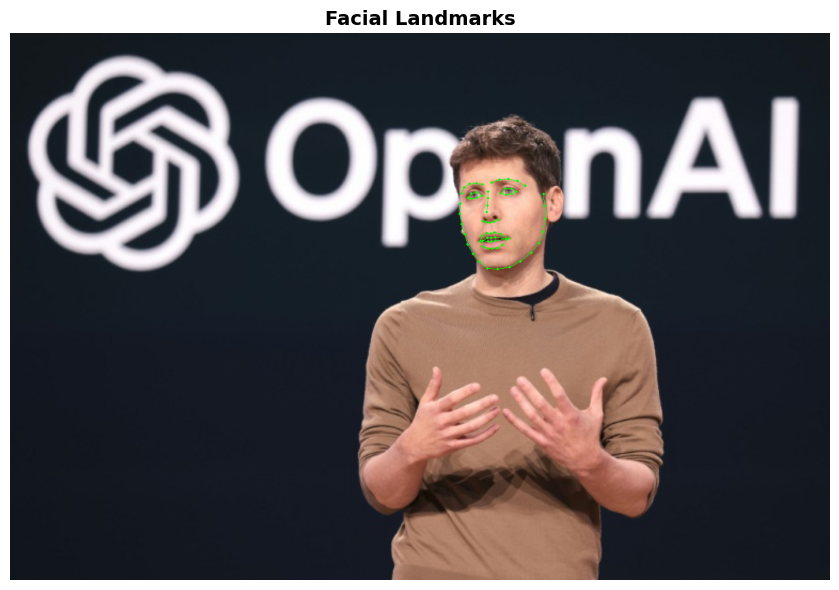

In [23]:
# Initialize landmark detector
if landmark_model_path:
    landmark_detector = FaceLandmarkDetector(landmark_model_path)
else:
    landmark_detector = FaceLandmarkDetector()

print("✓ Landmark detector is ready!")
print("This detector works with OpenCV Facemark or estimated landmarks.")

# Example usage (uncomment to test with your image):
if image is not None and len(faces) > 0:
    # Get landmarks for the first detected face
    landmarks = landmark_detector.get_landmarks(image, faces[0])
    
    if landmarks is not None:
        print(f"Detected {len(landmarks)} facial landmarks")
        
        # Draw landmarks
        result = landmark_detector.draw_landmarks(image, landmarks)
        display_image(result, "Facial Landmarks")

## 4. Face Swapping <a name="swapping"></a>

Now comes the exciting part - face swapping! We'll implement the core algorithm:
1. Detect faces and landmarks in both source and target images
2. Align the faces using landmarks
3. Create a mask for seamless blending
4. Swap the faces using triangulation and warping
5. Blend the result using Poisson blending or similar techniques

In [24]:
class FaceSwapper:
    """
    A class for swapping faces between images.
    """
    
    def __init__(self):
        """
        Initialize the face swapper.
        """
        pass
    
    def get_convex_hull(self, landmarks):
        """
        Get the convex hull of facial landmarks.
        
        Args:
            landmarks: Array of facial landmark points
            
        Returns:
            Convex hull points
        """
        points = np.array(landmarks, dtype=np.int32)
        hull = cv2.convexHull(points)
        return hull
    
    def get_face_mask(self, image_shape, landmarks):
        """
        Create a mask for the face region.
        
        Args:
            image_shape: Shape of the image (height, width)
            landmarks: Facial landmark points
            
        Returns:
            Binary mask
        """
        mask = np.zeros(image_shape[:2], dtype=np.uint8)
        hull = self.get_convex_hull(landmarks)
        cv2.fillConvexPoly(mask, hull, 255)
        return mask
    
    def delaunay_triangulation(self, landmarks, image_shape):
        """
        Perform Delaunay triangulation on facial landmarks.
        
        Args:
            landmarks: Facial landmark points
            image_shape: Shape of the image
            
        Returns:
            List of triangles (indices)
        """
        # Create Delaunay triangulation
        tri = Delaunay(landmarks)
        return tri.simplices
    
    def warp_triangle(self, img1, img2, t1, t2):
        """
        Warp a triangle from img1 to img2.
        
        Args:
            img1: Source image
            img2: Destination image
            t1: Triangle vertices in img1
            t2: Triangle vertices in img2
        """
        # Find bounding rectangles
        r1 = cv2.boundingRect(np.float32([t1]))
        r2 = cv2.boundingRect(np.float32([t2]))
        
        # Offset points by left top corner of the respective rectangles
        t1_rect = []
        t2_rect = []
        t2_rect_int = []
        
        for i in range(3):
            t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
            t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
            t2_rect_int.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
        
        # Get mask by filling triangle
        mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(t2_rect_int), (1.0, 1.0, 1.0), 16, 0)
        
        # Apply warp to small rectangular patches
        img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        
        size = (r2[2], r2[3])
        
        # Get affine transform
        warp_mat = cv2.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
        img2_rect = cv2.warpAffine(img1_rect, warp_mat, size, None, 
                                    flags=cv2.INTER_LINEAR, 
                                    borderMode=cv2.BORDER_REFLECT_101)
        
        # Apply mask and copy to destination
        img2_rect = img2_rect * mask
        
        # Copy triangular region
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
        
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2_rect
    
    def swap_faces(self, src_image, src_landmarks, dst_image, dst_landmarks):
        """
        Swap face from source image to destination image.
        
        Args:
            src_image: Source image containing the face to swap
            src_landmarks: Landmarks of the source face
            dst_image: Destination image where face will be placed
            dst_landmarks: Landmarks of the destination face
            
        Returns:
            Image with swapped face
        """
        # Convert images to float
        src_img = np.float32(src_image)
        dst_img = np.float32(dst_image)
        result = dst_img.copy()
        
        # Perform Delaunay triangulation on destination landmarks
        triangles = self.delaunay_triangulation(dst_landmarks, dst_image.shape)
        
        # Warp each triangle
        for triangle_indices in triangles:
            # Get triangle vertices
            t1 = [src_landmarks[i] for i in triangle_indices]
            t2 = [dst_landmarks[i] for i in triangle_indices]
            
            # Warp triangle
            self.warp_triangle(src_img, result, t1, t2)
        
        # Create mask for seamless cloning
        mask = self.get_face_mask(dst_image.shape, dst_landmarks)
        
        # Get center of the face for seamless cloning
        r = cv2.boundingRect(self.get_convex_hull(dst_landmarks))
        center = (r[0] + int(r[2] / 2), r[1] + int(r[3] / 2))
        
        # Seamless cloning
        result = np.uint8(result)
        output = cv2.seamlessClone(result, dst_image, mask, center, cv2.NORMAL_CLONE)
        
        return output

print("✓ FaceSwapper class defined!")

✓ FaceSwapper class defined!


In [25]:
# Initialize face swapper
face_swapper = FaceSwapper()

print("✓ Face swapper initialized!")
print("\nReady to swap faces!")
print("To use: result = face_swapper.swap_faces(src_img, src_landmarks, dst_img, dst_landmarks)")

✓ Face swapper initialized!

Ready to swap faces!
To use: result = face_swapper.swap_faces(src_img, src_landmarks, dst_img, dst_landmarks)


## 5. Complete Pipeline & Testing <a name="testing"></a>

Let's create a complete pipeline that combines all the components.

In [26]:
class FaceAnonymizer:
    """
    Complete pipeline for face detection and anonymization.
    """
    
    def __init__(self, detector_method='haar', landmark_model_path=None):
        """
        Initialize the face anonymizer.
        
        Args:
            detector_method: Face detection method ('haar' or 'dnn')
            landmark_model_path: Path to landmark model (optional)
        """
        self.face_detector = FaceDetector(method=detector_method)
        if landmark_model_path:
            self.landmark_detector = FaceLandmarkDetector(landmark_model_path)
        else:
            self.landmark_detector = FaceLandmarkDetector()
        self.face_swapper = FaceSwapper()
        print("✓ Face Anonymizer initialized!")
    
    def anonymize_image(self, target_image, source_image=None, visualize=False):
        """
        Anonymize faces in the target image.
        
        Args:
            target_image: Image to anonymize
            source_image: Image containing replacement face (if None, uses built-in methods)
            visualize: Whether to show intermediate steps
            
        Returns:
            Anonymized image
        """
        # Detect faces in target image
        target_faces = self.face_detector.detect(target_image)
        
        if len(target_faces) == 0:
            print("No faces detected in target image")
            return target_image
        
        print(f"Detected {len(target_faces)} face(s) in target image")
        
        if source_image is not None:
            # Detect face in source image
            source_faces = self.face_detector.detect(source_image)
            
            if len(source_faces) == 0:
                print("No faces detected in source image")
                return target_image
            
            # Get landmarks for source face
            source_landmarks = self.landmark_detector.get_landmarks(source_image, source_faces[0])
            
            if source_landmarks is None:
                print("Could not detect landmarks in source face")
                return target_image
            
            # Process each face in target image
            result = target_image.copy()
            
            for i, target_face in enumerate(target_faces):
                # Get landmarks for target face
                target_landmarks = self.landmark_detector.get_landmarks(result, target_face)
                
                if target_landmarks is not None:
                    print(f"Swapping face {i+1}/{len(target_faces)}...")
                    try:
                        result = self.face_swapper.swap_faces(
                            source_image, source_landmarks,
                            result, target_landmarks
                        )
                    except Exception as e:
                        print(f"Face swap failed for face {i+1}: {e}")
                        print("Falling back to blur anonymization for this face.")
                        result = self.simple_anonymize(result, [target_face], method='blur')
            
            return result
        else:
            # If no source image provided, use blur or pixelation for anonymization
            return self.simple_anonymize(target_image, target_faces)
    
    def simple_anonymize(self, image, faces, method='blur'):
        """
        Simple anonymization using blur or pixelation.
        
        Args:
            image: Input image
            faces: List of face bounding boxes
            method: 'blur' or 'pixelate'
            
        Returns:
            Anonymized image
        """
        result = image.copy()
        
        for (x, y, w, h) in faces:
            # Extract face region
            face_region = result[y:y+h, x:x+w]
            
            if method == 'blur':
                # Apply strong Gaussian blur
                face_region = cv2.GaussianBlur(face_region, (99, 99), 30)
            elif method == 'pixelate':
                # Pixelate by downscaling and upscaling
                small = cv2.resize(face_region, (16, 16), interpolation=cv2.INTER_LINEAR)
                face_region = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
            
            # Put back the anonymized region
            result[y:y+h, x:x+w] = face_region
        
        return result

print("✓ FaceAnonymizer class defined!")

✓ FaceAnonymizer class defined!


In [27]:
# Initialize the complete anonymizer
anonymizer = FaceAnonymizer(detector_method='haar', landmark_model_path=landmark_model_path)

print("\n" + "="*60)
print("Face Anonymization System Ready!")
print("="*60)
print("\nUsage Examples:")
print("\n1. Simple anonymization (blur):")
print("   result = anonymizer.simple_anonymize(image, faces, method='blur')")
print("\n2. Simple anonymization (pixelate):")
print("   result = anonymizer.simple_anonymize(image, faces, method='pixelate')")
print("\n3. Face swapping:")
print("   result = anonymizer.anonymize_image(target_img, source_img)")
print("\n4. Load an image:")
print("   image = cv2.imread('path/to/image.jpg')")
print("="*60)

✓ Haar Cascade loaded
loading data from : lbfmodel.yaml
✓ OpenCV Facemark initialized with LBF model!
✓ Face Anonymizer initialized!

Face Anonymization System Ready!

Usage Examples:

1. Simple anonymization (blur):
   result = anonymizer.simple_anonymize(image, faces, method='blur')

2. Simple anonymization (pixelate):
   result = anonymizer.simple_anonymize(image, faces, method='pixelate')

3. Face swapping:
   result = anonymizer.anonymize_image(target_img, source_img)

4. Load an image:
   image = cv2.imread('path/to/image.jpg')


## Next Steps

### To continue developing this project:

1. **Test with real images**: Load your own images and test the detection and anonymization
2. **Improve face swapping**: Fine-tune the blending parameters for more natural results
3. **Add more anonymization methods**: Implement additional techniques (e.g., artistic filters, emoji overlay)
4. **Batch processing**: Create functions to process multiple images at once
5. **Video support**: Extend the system to work with video files
6. **Performance optimization**: Use GPU acceleration for faster processing
7. **Evaluation metrics**: Implement metrics to measure anonymization quality

### Solution compatible with Python 3.13:
- ✅ **OpenCV only**: No external dependencies with compilation issues
- ✅ **Works out of the box**: All packages available via pip
- ✅ **Haar Cascade**: Fast and reliable face detection
- ✅ **OpenCV Facemark**: 68-point facial landmarks (with fallback estimation)
- ✅ **Delaunay triangulation**: Professional face swapping algorithm
- ✅ **Multiple anonymization methods**: Blur, pixelation, and face swapping

### Files you'll need:
- `lbfmodel.yaml` - For facial landmark detection (downloaded automatically)
- Sample images for testing (JPG, PNG, etc.)

### Alternative anonymization without face swapping:
Even if the landmark model fails to download, you can still use:
- Blur anonymization
- Pixelation anonymization
- These work with just face detection (no landmarks needed)

Good luck with your computer vision project! 🚀